In [2]:
import pandas as pd
weather = pd.read_csv("munich.csv", index_col="DATE")
weather

,STATION,NAME,PRCP,SNWD,TMAX,TMIN
DATE,,,,,,
2000-01-01,GME00123970,"HOLZKIRCHEN, GM",0.30,13.4,35,27
2000-01-02,GME00123970,"HOLZKIRCHEN, GM",0.00,11.4,42,26
2000-01-03,GME00123970,"HOLZKIRCHEN, GM",0.00,9.4,40,21
2000-01-04,GME00123970,"HOLZKIRCHEN, GM",0.09,8.3,43,20
2000-01-05,GME00123970,"HOLZKIRCHEN, GM",0.01,7.5,43,32
...,...,...,...,...,...,...
2021-12-27,GME00123970,"HOLZKIRCHEN, GM",0.04,0.0,47,37
2021-12-28,GME00123970,"HOLZKIRCHEN, GM",0.31,0.0,47,35
2021-12-29,GME00123970,"HOLZKIRCHEN, GM",0.54,0.0,50,42


In [3]:
core_weather = weather[["PRCP", "SNWD", "TMAX", "TMIN"]].copy()
# Farenheit To Celcius
core_weather["TMAX"] = core_weather["TMAX"].apply(lambda x: (x - 32)*0.5556)
core_weather["TMIN"] = core_weather["TMIN"].apply(lambda x: (x - 32)*0.5556)
# Dataframe object to datetime
core_weather.index = pd.to_datetime(core_weather.index)
# Rounding values
core_weather["TMIN"] = core_weather["TMIN"].round(decimals = 1)
core_weather["TMAX"] = core_weather["TMAX"].round(decimals = 1)
core_weather

,PRCP,SNWD,TMAX,TMIN
DATE,,,,
2000-01-01,0.30,13.4,1.7,-2.8
2000-01-02,0.00,11.4,5.6,-3.3
2000-01-03,0.00,9.4,4.4,-6.1
2000-01-04,0.09,8.3,6.1,-6.7
2000-01-05,0.01,7.5,6.1,0.0
...,...,...,...,...
2021-12-27,0.04,0.0,8.3,2.8
2021-12-28,0.31,0.0,8.3,1.7
2021-12-29,0.54,0.0,10.0,5.6


<AxesSubplot:xlabel='DATE'>

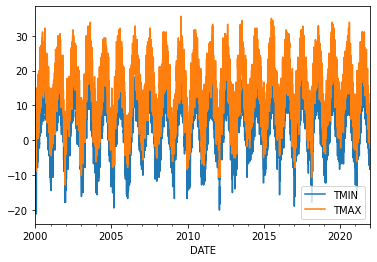

In [4]:
core_weather[["TMIN", "TMAX"]].plot()

<AxesSubplot:xlabel='DATE'>

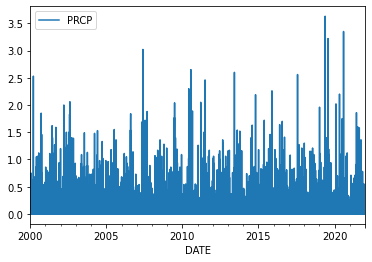

In [5]:
core_weather[["PRCP"]].plot()

In [6]:
# Building a target column for predictions
core_weather["target"] = core_weather.shift(-1)["TMAX"]

In [7]:
core_weather = core_weather.iloc[:-1,:].copy()
core_weather

,PRCP,SNWD,TMAX,TMIN,target
DATE,,,,,
2000-01-01,0.30,13.4,1.7,-2.8,5.6
2000-01-02,0.00,11.4,5.6,-3.3,4.4
2000-01-03,0.00,9.4,4.4,-6.1,6.1
2000-01-04,0.09,8.3,6.1,-6.7,6.1
2000-01-05,0.01,7.5,6.1,0.0,10.6
...,...,...,...,...,...
2021-12-26,0.17,0.0,5.0,0.6,8.3
2021-12-27,0.04,0.0,8.3,2.8,8.3
2021-12-28,0.31,0.0,8.3,1.7,10.0


In [8]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=.1)
predictors = ["PRCP", "TMAX", "TMIN"]

In [9]:
# Training model will include all data before the end of 2020, while testing will be done for 2021.
train = core_weather.loc[:"2020-12-31"]
test = core_weather.loc["2021-01-01":]

In [10]:
reg.fit(train[predictors], train["target"])

Ridge(alpha=0.1)

In [26]:
# Building an array of predicted values
predictions = reg.predict(test[predictors])

In [12]:
# Calculating mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test["target"], predictions)

2.863305130775958

In [13]:
# Building a series with actual and predicted values 
combined = pd.concat([test["target"], pd.Series(predictions, index = test.index)], axis = 1)
combined.columns = ["actual", "predicted"]
combined["predicted"] = combined["predicted"].round(decimals = 1)

In [14]:
combined

,actual,predicted
DATE,,
2021-01-01,-0.6,4.5
2021-01-02,-1.1,1.7
2021-01-03,-1.7,1.5
2021-01-04,-2.8,1.1
2021-01-05,-1.7,-0.1
...,...,...
2021-12-26,8.3,6.4
2021-12-27,8.3,9.8
2021-12-28,10.0,8.6


<AxesSubplot:xlabel='DATE'>

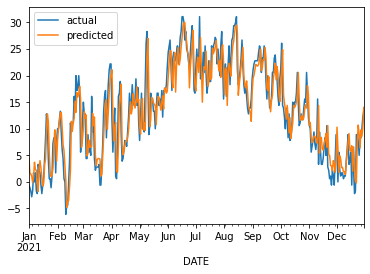

In [15]:
# Bulding a plot with actual and predicted values
combined.plot()

In [16]:
reg.coef_

array([-3.45036103,  0.72545785,  0.26499794])

In [24]:
# Adding monthly average; only previous data is used to calculate averages to that day
core_weather["monthly_avg"] = core_weather["TMAX"].groupby(core_weather.index.month).apply(lambda x: x.expanding(1).mean())
core_weather

,PRCP,SNWD,TMAX,TMIN,target,monthly_avg
DATE,,,,,,
2000-01-01,0.30,13.4,1.7,-2.8,5.6,1.700000
2000-01-02,0.00,11.4,5.6,-3.3,4.4,3.650000
2000-01-03,0.00,9.4,4.4,-6.1,6.1,3.900000
2000-01-04,0.09,8.3,6.1,-6.7,6.1,4.450000
2000-01-05,0.01,7.5,6.1,0.0,10.6,4.780000
...,...,...,...,...,...,...
2021-12-26,0.17,0.0,5.0,0.6,8.3,4.287445
2021-12-27,0.04,0.0,8.3,2.8,8.3,4.293363
2021-12-28,0.31,0.0,8.3,1.7,10.0,4.299264


In [20]:
# Seeing correlations
core_weather.corr()["target"]

PRCP          -0.070282
SNWD          -0.412484
TMAX           0.903702
TMIN           0.819756
target         1.000000
monthly_avg    0.807164
Name: target, dtype: float64

In [30]:
# Looking at days with maximum deviation of predictions from actual values
combined["diff"] = (combined["actual"] - combined["predicted"]).abs()
combined.sort_values("diff", ascending = False).head()

,actual,predicted,diff
DATE,,,
2021-11-11,3.3,14.4,11.1
2021-10-03,14.4,24.9,10.5
2021-04-05,1.1,11.2,10.1
2021-05-08,26.1,16.3,9.8
2021-02-26,5.6,15.4,9.8


In [37]:
# Counting days when predictions were true
combined.loc[combined["diff"] == 0].count()[0]

8

<AxesSubplot:xlabel='DATE'>

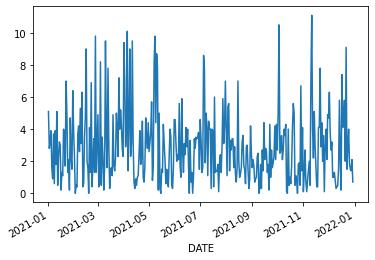

In [40]:
# A graph showing prediction deviations
combined.sort_values("diff", ascending = False)["diff"].plot()

In [41]:
# Temperture prediction error
combined["diff"].mean()

2.8640109890109895